In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import spacy

df = pd.read_csv("BooksDatasetClean.csv")
df = df.dropna(subset=['Category', 'Description'])
df['book_id'] = df.index

print(f"Total books: {len(df)}")
print(f"Shape: {df.shape}")

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total books: 65296
Shape: (65296, 9)


In [2]:
df.head()

,Title,Authors,Description,Category,Publisher,Price Starting With ($),Publish Date (Month),Publish Date (Year),book_id
7,Journey Through Heartsongs,"By Stepanek, Mattie J. T.",Collects poems written by the eleven-year-old ...,"Poetry , General",VSP Books,19.96,September,2001,7
8,In Search of Melancholy Baby,"By Aksyonov, Vassily, Heim, Michael Henry, and...",The Russian author offers an affectionate chro...,"Biography & Autobiography , General",Random House,4.99,June,1987,8
10,The Dieter's Guide to Weight Loss During Sex,"By Smith, Richard","A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets",Workman Publishing Company,4.99,January,1978,10
11,Germs : Biological Weapons and America's Secre...,"By Miller, Judith, Engelberg, Stephen, and Bro...","Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science",Simon & Schuster,4.99,October,2001,11
13,The Good Book: Reading the Bible with Mind and...,"By Gomes, Peter J.","""The Bible and the social and moral consequenc...","Religion , Biblical Biography , General",Harper Perennial,5.29,May,1998,13


In [3]:
import re

def preprocess_category(cat):
    if pd.isna(cat): return None
    cat = str(cat).strip()
    categories = [c.strip() for c in cat.split(',')]
    cleaned = []
    for c in categories:
        if c.lower().strip() == 'general': continue
        c = re.sub(r'\(.*?\)', '', c)
        c = re.sub(r'[()]|\d+', '', c)
        c = c.replace("'s", "s").replace("&", "and").replace("-", " ")
        c = c.lower().strip()
        c = ' '.join(c.split())
        if c: cleaned.append(c)
    return ', '.join(cleaned) if cleaned else None

df['category_cleaned'] = df['Category'].apply(preprocess_category)
df = df[df['category_cleaned'].notna()]

df_exploded = df.copy()
df_exploded['category_split'] = df_exploded['category_cleaned'].str.split(', ')
df_exploded = df_exploded.explode('category_split').reset_index(drop=True)

print(f"rows after explode: {len(df_exploded)}")
print(f"unique categories: {df_exploded['category_split'].nunique()}")

rows after explode: 144322
unique categories: 2010


In [4]:
df[['Category', 'category_cleaned']].head(10)

,Category,category_cleaned
7,"Poetry , General",poetry
8,"Biography & Autobiography , General",biography and autobiography
10,"Health & Fitness , Diet & Nutrition , Diets","health and fitness, diet and nutrition, diets"
11,"Technology & Engineering , Military Science","technology and engineering, military science"
13,"Religion , Biblical Biography , General","religion, biblical biography"
14,"Biography & Autobiography , Personal Memoirs","biography and autobiography, personal memoirs"
19,"Political Science , General",political science
21,"Pets , Cats , General","pets, cats"
26,"Political Science , General",political science
27,"Fiction , General",fiction


In [5]:
nlp = spacy.load("en_core_web_sm")
from collections import defaultdict

def lemmatize_category(cat):
    if pd.isna(cat) or not cat: return None
    doc = nlp(cat)
    return " ".join([token.lemma_ for token in doc if not token.is_punct]).strip()

df_exploded['category_lemmatized'] = df_exploded['category_split'].apply(lemmatize_category)

category_frequency = df_exploded['category_split'].value_counts()
lemma_to_original = defaultdict(list)

for idx, row in df_exploded[['category_split', 'category_lemmatized']].drop_duplicates().iterrows():
    lemma_to_original[row['category_lemmatized']].append(row['category_split'])

canonical_mapping = {}
for lemma, originals in lemma_to_original.items():
    freq_counter = {orig: category_frequency.get(orig, 0) for orig in originals}
    canonical = max(freq_counter, key=freq_counter.get)
    canonical_mapping[lemma] = canonical

df_exploded['category_canonical'] = df_exploded['category_lemmatized'].map(canonical_mapping)

print(f"canonical categories: {df_exploded['category_canonical'].nunique()}")
print(f"\ntop 10:")

canonical categories: 1997

top 10:


In [6]:
df_exploded['category_canonical'].value_counts().head(10)

category_canonical
fiction                   17721
juvenile fiction           6437
religion                   3686
romance                    3491
cooking                    2890
juvenile nonfiction        2665
history                    2583
business and economics     2542
historical                 2356
thrillers                  2299
Name: count, dtype: int64

In [7]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

all_categories = df_exploded['category_canonical'].unique().tolist()
all_embeddings = embedding_model.encode(all_categories, show_progress_bar=True, device='cpu')

print(f"categories: {len(all_categories)}")
print(f"embedding shape: {all_embeddings.shape}")

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5060 Ti with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90.
If you want to use the NVIDIA GeForce RTX 5060 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(
Batches: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 73.63it/s]

categories: 1997
embedding shape: (1997, 384)


## explaining why k=12 is a good choice

In [8]:
# test k from 5 to 25
K_range = range(5, 26)
inertias = []
silhouettes = []
db_scores = []
ch_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(all_embeddings)
    
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(all_embeddings, labels))
    db_scores.append(davies_bouldin_score(all_embeddings, labels))
    ch_scores.append(calinski_harabasz_score(all_embeddings, labels))
    
    if k % 5 == 0:
        print(f"k={k}: sil={silhouettes[-1]:.3f}, db={db_scores[-1]:.3f}")

k=5: sil=0.027, db=5.112
k=10: sil=0.032, db=4.380
k=15: sil=0.038, db=4.007
k=20: sil=0.042, db=3.852
k=25: sil=0.044, db=3.738


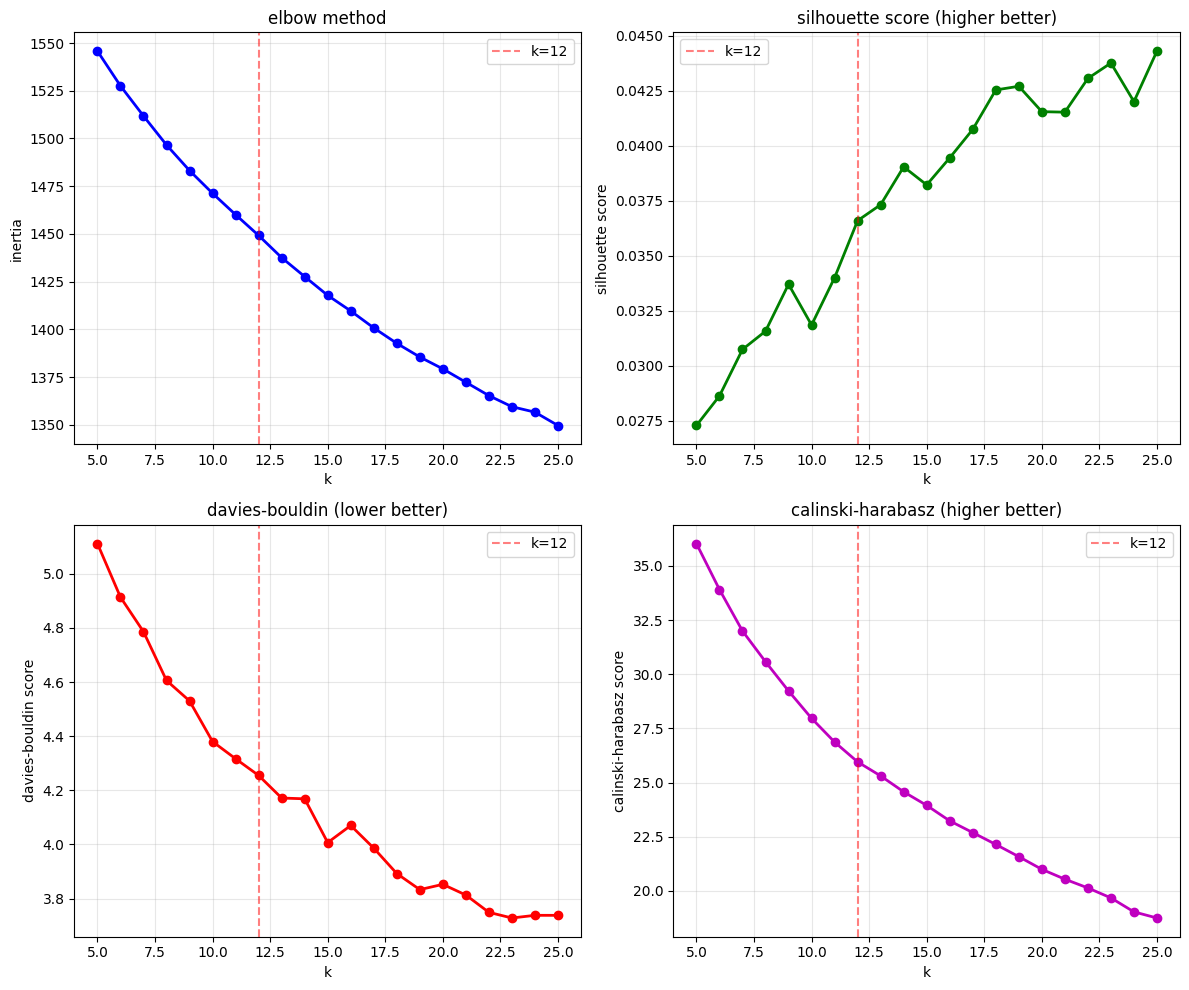


k=12 metrics:
  silhouette: 0.0366
  davies-bouldin: 4.2550
  calinski-harabasz: 25.96


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# elbow plot
axes[0, 0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('k')
axes[0, 0].set_ylabel('inertia')
axes[0, 0].set_title('elbow method')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(x=12, color='r', linestyle='--', alpha=0.5, label='k=12')
axes[0, 0].legend()

# silhouette score (higher is better)
axes[0, 1].plot(K_range, silhouettes, 'go-', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('k')
axes[0, 1].set_ylabel('silhouette score')
axes[0, 1].set_title('silhouette score (higher better)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(x=12, color='r', linestyle='--', alpha=0.5, label='k=12')
axes[0, 1].legend()

# davies-bouldin score (lower is better)
axes[1, 0].plot(K_range, db_scores, 'ro-', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('k')
axes[1, 0].set_ylabel('davies-bouldin score')
axes[1, 0].set_title('davies-bouldin (lower better)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(x=12, color='r', linestyle='--', alpha=0.5, label='k=12')
axes[1, 0].legend()

# calinski-harabasz score (higher is better)
axes[1, 1].plot(K_range, ch_scores, 'mo-', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('k')
axes[1, 1].set_ylabel('calinski-harabasz score')
axes[1, 1].set_title('calinski-harabasz (higher better)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(x=12, color='r', linestyle='--', alpha=0.5, label='k=12')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('k_selection_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nk=12 metrics:")
print(f"  silhouette: {silhouettes[7]:.4f}")
print(f"  davies-bouldin: {db_scores[7]:.4f}")
print(f"  calinski-harabasz: {ch_scores[7]:.2f}")

In [10]:
# final clustering with k=12
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(all_embeddings)

category_to_cluster = dict(zip(all_categories, cluster_labels))

# add to dataframe
df_exploded['cluster_id'] = df_exploded['category_canonical'].map(category_to_cluster)

# cluster distribution
from collections import Counter
cluster_counts = Counter(cluster_labels)

print("cluster size distribution (by unique categories):")
for cid in sorted(cluster_counts.keys()):
    count = cluster_counts[cid]
    pct = count / len(all_categories) * 100
    print(f"  cluster {cid:2d}: {count:4d} categories ({pct:5.1f}%)")

cluster size distribution (by unique categories):
  cluster  0:  175 categories (  8.8%)
  cluster  1:  101 categories (  5.1%)
  cluster  2:  130 categories (  6.5%)
  cluster  3:  157 categories (  7.9%)
  cluster  4:  122 categories (  6.1%)
  cluster  5:  180 categories (  9.0%)
  cluster  6:  148 categories (  7.4%)
  cluster  7:  238 categories ( 11.9%)
  cluster  8:   84 categories (  4.2%)
  cluster  9:  186 categories (  9.3%)
  cluster 10:  140 categories (  7.0%)
  cluster 11:  336 categories ( 16.8%)


In [11]:
# calculate silhouette score for each cluster using full dataset
cluster_quality = []

for cid in range(12):
    mask = cluster_labels == cid
    cluster_size = np.sum(mask)
    
    if cluster_size > 1:
        # use subset of data for efficiency
        cluster_indices = np.where(mask)[0]
        
        # get embeddings for this cluster
        cluster_emb = all_embeddings[mask]
        
        # sample other clusters for comparison
        other_mask = ~mask
        other_indices = np.where(other_mask)[0]
        
        if len(other_indices) > 500:
            other_sample = np.random.choice(other_indices, 500, replace=False)
        else:
            other_sample = other_indices
            
        # combine for silhouette calculation
        combined_indices = np.concatenate([cluster_indices, other_sample])
        combined_emb = all_embeddings[combined_indices]
        combined_labels = np.array([cid]*len(cluster_indices) + [-1]*len(other_sample))
        
        sil = silhouette_score(combined_emb, combined_labels)
        
        cluster_quality.append({
            'cluster': cid,
            'size': cluster_size,
            'silhouette': sil
        })

quality_df = pd.DataFrame(cluster_quality)
quality_df = quality_df.sort_values('silhouette')

print("cluster quality (sorted by silhouette):\n")
print(quality_df.to_string(index=False))
print(f"\nmean: {quality_df['silhouette'].mean():.4f}")

cluster quality (sorted by silhouette):

 cluster  size  silhouette
      11   336    0.011572
       7   238    0.014469
       8    84    0.016612
       1   101    0.016681
      10   140    0.019067
       3   157    0.020717
       5   180    0.022966
       0   175    0.025014
       2   130    0.025220
       4   122    0.031930
       9   186    0.033460
       6   148    0.035993

mean: 0.0228


In [12]:
# show top categories in worst clusters
category_freq = df_exploded['category_canonical'].value_counts()

worst_clusters = [11, 7, 8]  # lowest silhouette scores

for cid in worst_clusters:
    cluster_cats = [cat for cat, label in category_to_cluster.items() if label == cid]
    cluster_freq = category_freq[category_freq.index.isin(cluster_cats)].sort_values(ascending=False)
    
    print(f"\ncluster {cid} (size={len(cluster_cats)}, sil={quality_df[quality_df['cluster']==cid]['silhouette'].values[0]:.4f}):")
    print("-" * 70)
    
    # show top 20
    for cat, count in cluster_freq.head(20).items():
        print(f"  {cat:45s} {count:5d}")
    
    print(f"  ... ({len(cluster_cats)-20} more categories)")
    print(f"  total occurrences: {cluster_freq.sum():,}")


cluster 11 (size=336, sil=0.0116):
----------------------------------------------------------------------
  romance                                        3491
  cooking                                        2890
  reference                                      1765
  suspense                                       1317
  family and relationships                       1280
  travel                                         1189
  self help                                      1087
  humor                                          1038
  fantasy                                         990
  science                                         851
  house and home                                  807
  military                                        523
  family                                          504
  women                                           418
  holidays and celebrations                       394
  media tie in                                    369
  friendship                 

## sub clustering to cluster 11

cluster 11: 336 categories
  sub k=2: silhouette=0.0289
  sub k=3: silhouette=0.0309
  sub k=4: silhouette=0.0332
  sub k=5: silhouette=0.0321
  sub k=6: silhouette=0.0311
  sub k=7: silhouette=0.0339


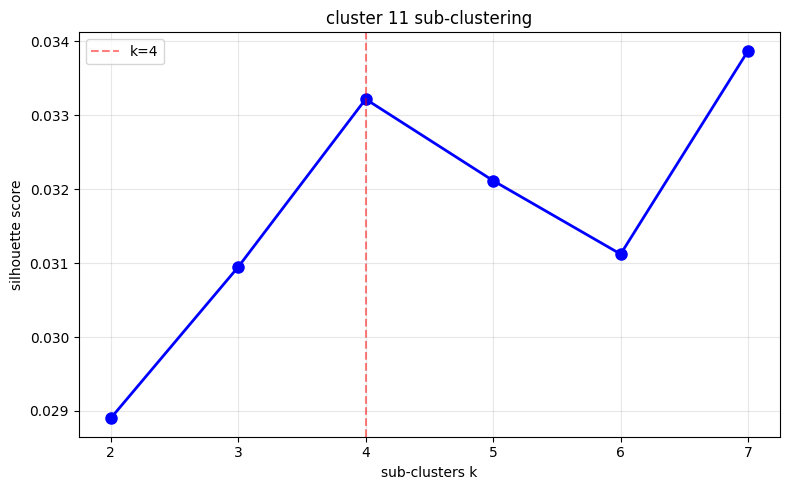

In [13]:
# get cluster 11 embeddings
cluster_11_cats = [cat for cat, label in category_to_cluster.items() if label == 11]
cluster_11_indices = [all_categories.index(cat) for cat in cluster_11_cats]
cluster_11_embeddings = all_embeddings[cluster_11_indices]

print(f"cluster 11: {len(cluster_11_cats)} categories")

# test sub-clustering with different k
sub_K_range = range(2, 8)
sub_silhouettes = []

for k in sub_K_range:
    km_sub = KMeans(n_clusters=k, random_state=42, n_init=10)
    sub_labels = km_sub.fit_predict(cluster_11_embeddings)
    sil = silhouette_score(cluster_11_embeddings, sub_labels)
    sub_silhouettes.append(sil)
    print(f"  sub k={k}: silhouette={sil:.4f}")

# plot
plt.figure(figsize=(8, 5))
plt.plot(sub_K_range, sub_silhouettes, 'bo-', linewidth=2, markersize=8)
plt.xlabel('sub-clusters k')
plt.ylabel('silhouette score')
plt.title('cluster 11 sub-clustering')
plt.grid(True, alpha=0.3)
plt.axvline(x=4, color='r', linestyle='--', alpha=0.5, label='k=4')
plt.legend()
plt.tight_layout()
plt.savefig('cluster11_subclustering.png', dpi=150)
plt.show()

In [14]:
# split cluster 11 into 4 sub-clusters
kmeans_sub = KMeans(n_clusters=4, random_state=42, n_init=10)
sub_labels = kmeans_sub.fit_predict(cluster_11_embeddings)

# show sub-cluster contents
for sub_id in range(4):
    sub_cats = [cluster_11_cats[i] for i in range(len(cluster_11_cats)) if sub_labels[i] == sub_id]
    sub_freq = category_freq[category_freq.index.isin(sub_cats)].sort_values(ascending=False)
    
    print(f"\nsub-cluster 11.{sub_id} ({len(sub_cats)} categories, {sub_freq.sum():,} occurrences):")
    print("-" * 70)
    
    for cat, count in sub_freq.head(15).items():
        print(f"  {cat:45s} {count:5d}")


sub-cluster 11.0 (74 categories, 5,209 occurrences):
----------------------------------------------------------------------
  travel                                         1189
  fantasy                                         990
  holidays and celebrations                       394
  fantasy and magic                               338
  music                                           288
  paranormal                                      230
  people and places                               204
  sagas                                           180
  holiday                                         111
  trivia                                           82
  erotica                                          81
  puzzles                                          72
  adventure                                        71
  halloween                                        70
  legends                                          69

sub-cluster 11.1 (48 categories, 4,146 occurrences):
-----------

## stop spliting too messy

In [15]:
# create final cluster mapping
# original 12 clusters, split cluster 11 into 4 parts

final_cluster_mapping = {}

for cat, cid in category_to_cluster.items():
    if cid != 11:
        # keep original cluster
        final_cluster_mapping[cat] = cid
    else:
        # find which sub-cluster it belongs to
        cat_idx = cluster_11_cats.index(cat)
        sub_id = sub_labels[cat_idx]
        
        # assign new cluster id: 11.0->11, 11.1->12, 11.2->13, 11.3->14
        final_cluster_mapping[cat] = 11 + sub_id

# add to dataframe
df_exploded['final_cluster'] = df_exploded['category_canonical'].map(final_cluster_mapping)

# show final distribution

for cid in sorted(df_exploded['final_cluster'].unique()):
    count = (df_exploded['final_cluster'] == cid).sum()
    n_cats = len([c for c, clust in final_cluster_mapping.items() if clust == cid])
    print(f"cluster {cid:2d}: {n_cats:3d} categories, {count:6d} occurrences")

print(f"\ntotal: {df_exploded['final_cluster'].nunique()} clusters")

cluster  0: 175 categories,   4651 occurrences
cluster  1: 101 categories,   4942 occurrences
cluster  2: 130 categories,   5630 occurrences
cluster  3: 157 categories,  46547 occurrences
cluster  4: 122 categories,   9644 occurrences
cluster  5: 180 categories,   6297 occurrences
cluster  6: 148 categories,   5240 occurrences
cluster  7: 238 categories,  17923 occurrences
cluster  8:  84 categories,   4727 occurrences
cluster  9: 186 categories,   4252 occurrences
cluster 10: 140 categories,   4753 occurrences
cluster 11:  74 categories,   5209 occurrences
cluster 12:  48 categories,   4146 occurrences
cluster 13:  44 categories,   7683 occurrences
cluster 14: 170 categories,  12678 occurrences

total: 15 clusters


## name cluster

In [16]:
# show top categories for each cluster for manual naming
category_freq = df_exploded['category_canonical'].value_counts()

for cid in sorted(df_exploded['final_cluster'].unique()):
    cluster_cats = [cat for cat, clust in final_cluster_mapping.items() if clust == cid]
    cluster_freq = category_freq[category_freq.index.isin(cluster_cats)].sort_values(ascending=False)
    
    print(f"\ncluster {cid:2d} ({len(cluster_cats)} cats, {cluster_freq.sum():,} occur):")
    print("-" * 70)
    for cat, count in cluster_freq.head(15).items():
        print(f"  {cat:45s} {count:5d}")


cluster  0 (175 cats, 4,651 occur):
----------------------------------------------------------------------
  computers                                       836
  beginner                                        517
  methods                                         398
  technology and engineering                      385
  form                                            334
  mathematics                                     189
  architecture                                    129
  programming languages                           115
  operating systems                                89
  physics                                          75
  astronomy                                        61
  counting and numbers                             56
  internet                                         55
  hardware                                         51
  science and technology                           46

cluster  1 (101 cats, 4,942 occur):
---------------------------------------------

In [17]:
CLUSTER_NAMES = {
    0: 'Technology & Math',              # computers, tech, math, physics
    1: 'Language & Culture',             # contemporary, language arts, ethnic
    2: 'Nature & Pets',                  # animals, pets, gardening, nature
    3: 'Fiction & Literature',           # fiction, juvenile, biography, mystery
    4: 'Religion & Spirituality',        # religion, christian, philosophy
    5: 'Business & Finance',             # business, economics, careers, finance
    6: 'Geography & Regional',           # united states, europe, westerns
    7: 'History & Social Science',       # history, political science, psychology
    8: 'Sports & Fitness',               # health & fitness, sports, games
    9: 'Medical & Nutrition',            # medical, diet, health, life sciences
    10: 'Arts & Crafts',                 # crafts, art, photography, design
    11: 'Entertainment & Travel',        # travel, fantasy, music, holidays
    12: 'Cooking & Food',                # cooking, diets, beverages
    13: 'Family & Romance',              # romance, family, relationships
    14: 'General & Miscellaneous'        # reference, suspense, self help, humor
}

# apply names
df_exploded['cluster_name'] = df_exploded['final_cluster'].map(CLUSTER_NAMES)

# show distribution
print("final cluster distribution with names:\n")
for cid in sorted(CLUSTER_NAMES.keys()):
    name = CLUSTER_NAMES[cid]
    count = (df_exploded['final_cluster'] == cid).sum()
    pct = count / len(df_exploded) * 100
    print(f"{cid:2d}. {name:30s}: {count:6d} ({pct:5.1f}%)")

final cluster distribution with names:

 0. Technology & Math             :   4651 (  3.2%)
 1. Language & Culture            :   4942 (  3.4%)
 2. Nature & Pets                 :   5630 (  3.9%)
 3. Fiction & Literature          :  46547 ( 32.3%)
 4. Religion & Spirituality       :   9644 (  6.7%)
 5. Business & Finance            :   6297 (  4.4%)
 6. Geography & Regional          :   5240 (  3.6%)
 7. History & Social Science      :  17923 ( 12.4%)
 8. Sports & Fitness              :   4727 (  3.3%)
 9. Medical & Nutrition           :   4252 (  2.9%)
10. Arts & Crafts                 :   4753 (  3.3%)
11. Entertainment & Travel        :   5209 (  3.6%)
12. Cooking & Food                :   4146 (  2.9%)
13. Family & Romance              :   7683 (  5.3%)
14. General & Miscellaneous       :  12678 (  8.8%)


## multi-label patterns

In [18]:
# analyze multi-label patterns
book_clusters = df_exploded.groupby('book_id')['cluster_name'].apply(list).reset_index()
book_clusters['num_labels'] = book_clusters['cluster_name'].apply(lambda x: len(set(x)))

print("labels per book distribution:")
print(book_clusters['num_labels'].value_counts().sort_index())
print(f"\nmean: {book_clusters['num_labels'].mean():.2f}")

print("sample books with 3+ labels:")

multi_label_books = book_clusters[book_clusters['num_labels'] >= 3].sample(5, random_state=42)

for idx, row in multi_label_books.iterrows():
    book_id = row['book_id']
    book_info = df[df['book_id'] == book_id].iloc[0]
    
    # get categories and their clusters
    book_cats = df_exploded[df_exploded['book_id'] == book_id][['category_canonical', 'cluster_name']]
    
    print(f"\nTitle: {book_info['Title'][:60]}")
    print(f"Categories ({len(book_cats)}):")
    for _, cat_row in book_cats.iterrows():
        print(f"  - {cat_row['category_canonical']:40s} → {cat_row['cluster_name']}")
    print(f"Unique clusters: {set(row['cluster_name'])}")

labels per book distribution:
num_labels
1    30679
2    26618
3     7658
4      341
Name: count, dtype: int64

mean: 1.66
sample books with 3+ labels:

Title: The Road to Paradise Island
Categories (3):
  - fiction                                  → Fiction & Literature
  - romance                                  → Family & Romance
  - suspense                                 → General & Miscellaneous
Unique clusters: {'General & Miscellaneous', 'Family & Romance', 'Fiction & Literature'}

Title: Witch Child
Categories (4):
  - young adult fiction                      → Fiction & Literature
  - historical                               → History & Social Science
  - united states                            → Geography & Regional
  - colonial and revolutionary periods       → History & Social Science
Unique clusters: {'Geography & Regional', 'History & Social Science', 'Fiction & Literature'}

Title: Anger: A Novel
Categories (3):
  - fiction                                  → Fiction 

In [19]:
# filter out "General & Miscellaneous" when other labels exist
# better keep more info

def filter_labels(labels):
    unique = list(set(labels))
    if len(unique) > 1 and 'General & Miscellaneous' in unique:
        unique.remove('General & Miscellaneous')
    return unique

book_labels_filtered = df_exploded.groupby('book_id').agg({
    'Title': 'first',
    'Authors': 'first',
    'Description': 'first',
    'Publisher': 'first',
    'cluster_name': lambda x: filter_labels(list(x))
}).reset_index()

book_labels_filtered.columns = ['book_id', 'Title', 'Authors', 'Description', 'Publisher', 'labels']
book_labels_filtered['num_labels'] = book_labels_filtered['labels'].apply(len)

print("after filtering 'General & Miscellaneous':")
print(book_labels_filtered['num_labels'].value_counts().sort_index())
print(f"\nmean: {book_labels_filtered['num_labels'].mean():.2f}")

# compare before/after
print(f"\nbefore: {book_clusters['num_labels'].mean():.2f} labels/book")
print(f"after:  {book_labels_filtered['num_labels'].mean():.2f} labels/book")

after filtering 'General & Miscellaneous':
num_labels
1    38048
2    21864
3     5098
4      286
Name: count, dtype: int64

mean: 1.50

before: 1.66 labels/book
after:  1.50 labels/book


In [20]:
# cluster-level stats
cluster_stats = df_exploded.groupby('cluster_name').agg({
    'category_canonical': 'nunique',
    'book_id': 'count'
}).reset_index()

cluster_stats.columns = ['cluster', 'n_categories', 'n_occurrences']
cluster_stats = cluster_stats.sort_values('n_occurrences', ascending=False)

print("\ncluster statistics:")
print(cluster_stats.to_string(index=False))

print(f"books: {len(book_labels_filtered):,}")
print(f"unique categories (original): {df_exploded['category_canonical'].nunique():,}")
print(f"final clusters: {len(CLUSTER_NAMES)}")
print(f"avg labels per book: {book_labels_filtered['num_labels'].mean():.2f}")

print(f"\nlabels per book:")
for n in sorted(book_labels_filtered['num_labels'].unique()):
    count = (book_labels_filtered['num_labels'] == n).sum()
    pct = count / len(book_labels_filtered) * 100
    print(f"  {n} label(s): {count:5d} books ({pct:5.1f}%)")




cluster statistics:
                 cluster  n_categories  n_occurrences
    Fiction & Literature           157          46547
History & Social Science           238          17923
 General & Miscellaneous           170          12678
 Religion & Spirituality           122           9644
        Family & Romance            44           7683
      Business & Finance           180           6297
           Nature & Pets           130           5630
    Geography & Regional           148           5240
  Entertainment & Travel            74           5209
      Language & Culture           101           4942
           Arts & Crafts           140           4753
        Sports & Fitness            84           4727
       Technology & Math           175           4651
     Medical & Nutrition           186           4252
          Cooking & Food            48           4146
books: 65,296
unique categories (original): 1,997
final clusters: 15
avg labels per book: 1.50

labels per book:
  

In [21]:
# evaluate final 15 clusters
final_quality = []

for cid in range(15):
    mask = np.array([final_cluster_mapping[cat] == cid for cat in all_categories])
    cluster_size = np.sum(mask)
    
    if cluster_size > 1:
        cluster_indices = np.where(mask)[0]
        other_indices = np.where(~mask)[0]
        
        # sample for efficiency
        if len(other_indices) > 500:
            other_sample = np.random.choice(other_indices, 500, replace=False)
        else:
            other_sample = other_indices
        
        combined_indices = np.concatenate([cluster_indices, other_sample])
        combined_emb = all_embeddings[combined_indices]
        combined_labels = np.array([cid]*len(cluster_indices) + [-1]*len(other_sample))
        
        sil = silhouette_score(combined_emb, combined_labels)
        
        final_quality.append({
            'cluster_id': cid,
            'cluster_name': CLUSTER_NAMES[cid],
            'n_categories': cluster_size,
            'silhouette': sil
        })

quality_final_df = pd.DataFrame(final_quality).sort_values('silhouette')

print("final cluster quality (sorted by silhouette):\n")
print(quality_final_df.to_string(index=False))
print(f"\nmean silhouette: {quality_final_df['silhouette'].mean():.4f}")
print(f"std silhouette: {quality_final_df['silhouette'].std():.4f}")

# compare with original k=12 確認一下有沒有比15更好
print("comparison:")
print(f"  original k=12 mean silhouette: 0.0230")
print(f"  final k=15 mean silhouette: {quality_final_df['silhouette'].mean():.4f}")

final cluster quality (sorted by silhouette):

 cluster_id             cluster_name  n_categories  silhouette
         11   Entertainment & Travel            74   -0.002142
         14  General & Miscellaneous           170    0.004191
         13         Family & Romance            44    0.006004
         12           Cooking & Food            48    0.009193
          7 History & Social Science           238    0.015198
          1       Language & Culture           101    0.016873
          8         Sports & Fitness            84    0.016970
         10            Arts & Crafts           140    0.018575
          3     Fiction & Literature           157    0.019986
          0        Technology & Math           175    0.023956
          5       Business & Finance           180    0.024410
          2            Nature & Pets           130    0.024924
          4  Religion & Spirituality           122    0.032373
          9      Medical & Nutrition           186    0.032550
        

In [22]:
# merge labels back to original dataframe
df_final = df[['book_id', 'Title', 'Authors', 'Description', 'Publisher', 
               'Category', 'Publish Date (Month)', 'Publish Date (Year)', 
               'Price Starting With ($)']].drop_duplicates('book_id')

# merge with labels
df_final = df_final.merge(
    book_labels_filtered[['book_id', 'labels', 'num_labels']], 
    on='book_id', 
    how='left'
)

# convert list to string for csv
df_final['labels_str'] = df_final['labels'].apply(lambda x: '; '.join(x) if isinstance(x, list) else '')

print(f"final dataset shape: {df_final.shape}")
print(f"books with labels: {df_final['labels'].notna().sum()}")
print(f"\nsample rows:\n")
print(df_final[['Title', 'Category', 'labels_str', 'num_labels']].head(10).to_string(index=False))

# save
df_final.to_csv('books_with_clusters.csv', index=False)
print(f"\nsaved to: books_with_clusters.csv")

final dataset shape: (65296, 12)
books with labels: 65296

sample rows:

                                                                 Title                                      Category                                            labels_str  num_labels
                                            Journey Through Heartsongs                              Poetry , General                                  Fiction & Literature           1
                                          In Search of Melancholy Baby           Biography & Autobiography , General                                  Fiction & Literature           1
                          The Dieter's Guide to Weight Loss During Sex   Health & Fitness , Diet & Nutrition , Diets Cooking & Food; Medical & Nutrition; Sports & Fitness           3
                   Germs : Biological Weapons and America's Secret War   Technology & Engineering , Military Science           Technology & Math; History & Social Science           2
            

## summary by chatgpt

**1. books_with_clusters.csv**  
- 65,296 books with cluster labels  
- Columns: Title, Authors, Category, labels, etc.

**2. books_labeled_final.csv**  
- Simplified version with labels only

**3. clustering_artifacts.pkl**  
- Embeddings, mappings, quality metrics

**4. k_selection_analysis.png**  
- Elbow and silhouette plots for k selection

**5. cluster11_subclustering.png**  
- Sub-clustering analysis

---

### Summary
- Books processed: **65,296**  
- Original categories: **1,997**  
- Final clusters: **15**  
- Avg labels/book: **1.50**  
- Mean silhouette: **`quality_final_df['silhouette'].mean():.4f`**